# Comparison of DFT and FFT
In this Jupyter notebook I compare different algorithms to obtain the Discrete Fourier Transform.
First import the numpy stuff:

In [1]:
import numpy as np
from numpy import exp, pi

Below is a naive/brute force implementation of the DFT:

In [7]:
def DFT_brute_force(signal, inverse=False):
    """
    Computes the DFT in a naive way
    Input: 
        signal    1d-numpy array
                  signal
        inverse   bool (OPTIONAL)
                  if true, compute the inverse DFT
    Returns:
        transformed  1d-numpy array
                  Fourier Transform of the signal
                
    """
    n = len(signal)
    transformed = np.zeros(signal.shape, dtype=complex)
    for k in range(n): # for each transformed element
        for l in range(n): # compute sum in loop
            if not inverse:
                transformed[k] += signal[l] * exp(-2j * pi * k * l / n)
            else: 
                transformed[k] += signal[l] * exp(2j * pi * k * l / n)
    return transformed

It is a bit more efficient to solve the DFT with a single matrix-vector-multiplication

In [13]:
def DFT(signal, inverse=False):
    """
    Computes the DFT by a matrix-vector-multiplication
    Input: 
        signal    1d-numpy array
                  signal
        inverse   bool (OPTIONAL)
                  if true, compute the inverse DFT
    Returns:
        transformed  1d-numpy array
                  Fourier Transform of the signal
                
    """
    n = len(signal)
    k_array = np.arange(n)
    if not inverse:
        W = exp(-2j * pi * np.outer(k_array, k_array) / n) # DFT matrix
    else:
        W = exp(2j * pi * np.outer(k_array, k_array) / n) # inverse DFT matrix
    return W.dot(signal) # matrix vector product

This recursive FFT algorithm enables a better time complexity when obtaining the Discrete Fourier Transform of a signal:

In [14]:
def FFT(signal, cutoff=16, w=None):
    """
    Computes the FFT with a recursive implementation of the Cooley-Tukey algorithm
    Inputs:
        signal     1d-numpy array
                   signal of length 2**x, type(x)=int
        cutoff     int, OPTIONAL 2**x
                   size of the 'lowest split level' to compute the DFT on
        inverse    bool OPTIONAL 
                   Returns the IFFT if true
    Returns:
        output     1d-numpy array
                   FFT of the signal
    """
    n = len(signal)
    if (n == 1): # trivial case
        return signal
    if (n <= cutoff): # cutoff with DFT
        return DFT(signal)
    output = np.zeros(n, dtype=complex)
    m = int(n/2)
    signal = signal.reshape(m, 2) # split signal in even, odd
    even, odd = signal[:,0], signal[:,1]
    if w is None: # compute twiddle factors if not given
        w = np.exp(-2j * np.pi * np.arange(m) / n)
    else:
        w = w[0:n-1:2] # reuse twiddle factors
    e = FFT(even, cutoff, w)     # even FFT
    o = w * FFT(odd, cutoff, w)  # odd FFT
    output[:m] = e + o
    output[m:] = e - o
    return output

Just some test function to validate the implementations:

In [15]:
import timeit
import statistics
def test(func, n=2**8, samples=10):
    """
    Test function
    """
    data = np.random.randint(-10, 10, size=n) + 1j*np.random.randint(-10, 10, size=n)
    compare = np.fft.fft(data) - func(data)
    if max(abs(compare)) > 1e-6:
        print('Implementation wrong!')
        return
    f = lambda: func(data)
    times = timeit.Timer(f).repeat(samples, 1)
    mean = statistics.mean(times)
    return mean

Execution times for the different algorithms with data size n=256:

In [16]:
test(DFT_brute_force)

0.1043695999999997

In [17]:
test(DFT)

0.005651550000002459

In [18]:
test(FFT)

0.0005906699999997045

Test function to run benchmarks for different FFT implementations:

In [19]:
import math
import matplotlib.pyplot as plt
from IPython.display import HTML, display
#import tabulate
%matplotlib notebook
def testCycle(funcs, start=2**1, end=2**8, samples=10, verbose=False):
    n = start
    iterations = []
    times = [[] for f in funcs]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    while n <= end:
        row = []
        iterations.append(n)
        if verbose:
            ax.clear()
            plt.xscale("log", basex=2)
            plt.yscale("log")
        for i, func in enumerate(funcs):
            time = test(func, n, samples)
            if time < 1e-3:
                time = test(func, n, int(samples/math.sqrt(time)))
            times[i].append(time)
            row.append(str(time))
            if verbose:
                ax.plot(iterations, times[i])
        if verbose:
            fig.canvas.draw()
        print(n, '|', ' | '.join(row))
        n *= 2
    #for i, func in enumerate(funcs):
    #    plt.plot(iterations, times[i])
    #plt.xscale("log", basex=2)
    #plt.yscale("log")
    return times

<IPython.core.display.Javascript object>


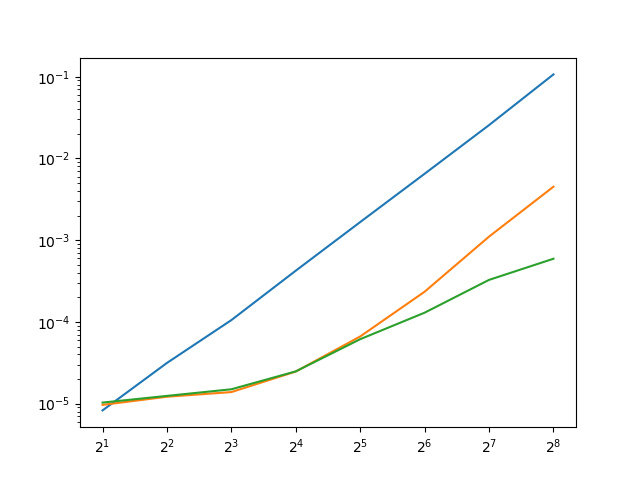

2 | 8.272477324253463e-06 | 9.662672605782341e-06 | 1.0310864446708608e-05
4 | 3.15077387485454e-05 | 1.2162477231358215e-05 | 1.2446658466441817e-05
8 | 0.00010535460852322165 | 1.3861476401815627e-05 | 1.5001125339543663e-05
16 | 0.0004239878243513225 | 2.4731980319707797e-05 | 2.4842698961804664e-05
32 | 0.0016671699999996291 | 6.641482820970744e-05 | 6.152897770952896e-05
64 | 0.006502099999998734 | 0.00023434217585701622 | 0.00012982828947370568
128 | 0.025604120000001274 | 0.0011064999999994996 | 0.00032694983050860567
256 | 0.10683301999999842 | 0.004515199999999453 | 0.0005932747252746435


In [20]:
testCycle((DFT_brute_force, DFT, FFT), verbose=True);

<IPython.core.display.Javascript object>


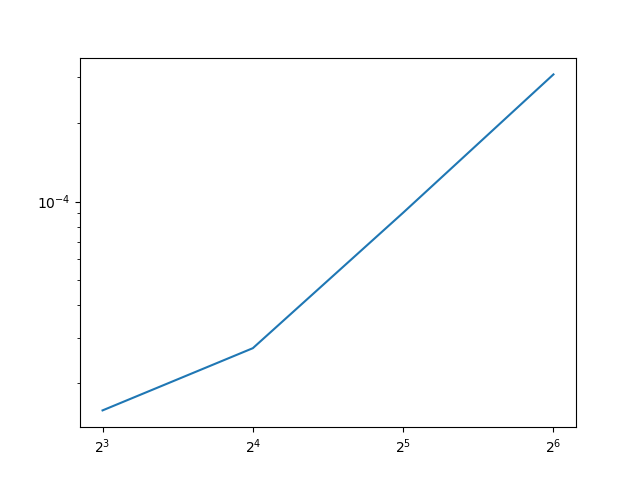

<IPython.core.display.Javascript object>


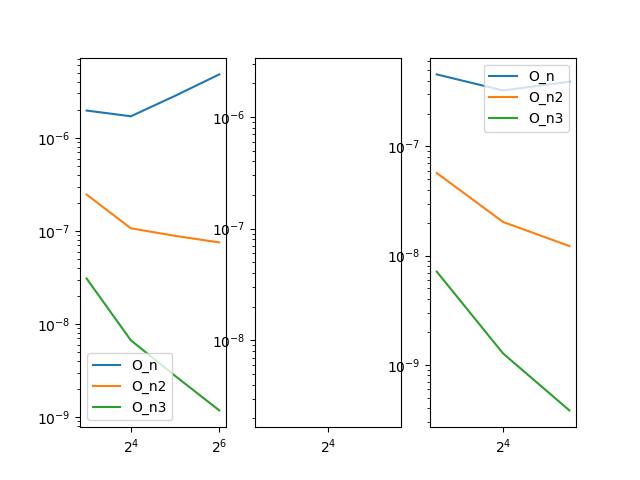

8 | 1.573914411553417e-05 | 1.5407453703328196e-05 | 3.6534302589962326e-06
16 | 2.7300773053492435e-05 | 2.7454212666994642e-05 | 5.204804497776996e-06
32 | 9.05620126925992e-05 | 7.705599999940819e-05 | 1.2527425237065716e-05


ValueError: operands could not be broadcast together with shapes (32,) (32,64) 

In [14]:
testCycle([DFT, FFT, np.fft.fft], end=2**12, verbose=True);

<IPython.core.display.Javascript object>


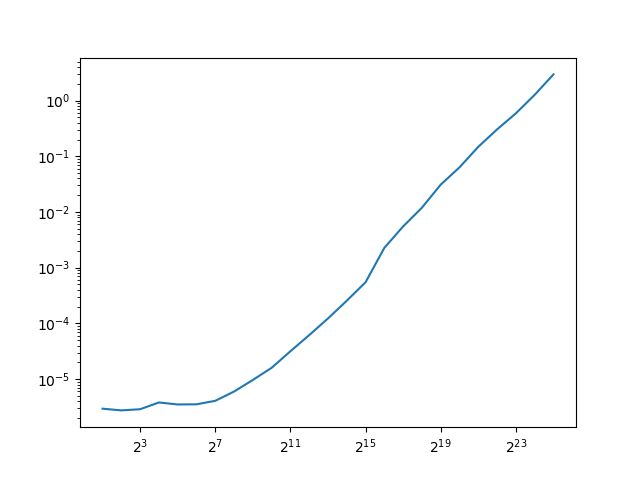

2 | 2.9475690395320985e-06
4 | 2.7450970017434e-06
8 | 2.882851196713257e-06
16 | 3.808137089860831e-06
32 | 3.5093742677804483e-06
64 | 3.529842615122111e-06
128 | 4.080565068637153e-06
256 | 5.98303693567669e-06
512 | 9.658823529215981e-06
1024 | 1.5966534653630738e-05
2048 | 3.166281767934861e-05
4096 | 6.166669310111655e-05
8192 | 0.00012272787286036577
16384 | 0.000255605466238751
32768 | 0.0005491721962621485
65536 | 0.002270779999997785
131072 | 0.00551009999999792
262144 | 0.011951350000006754
524288 | 0.03099871999999948
1048576 | 0.06330427000000043
2097152 | 0.1479933999999929
4194304 | 0.30384706000000106
8388608 | 0.5893468300000052
16777216 | 1.267481749999996
33554432 | 2.9487217499999927


In [13]:
testCycle([np.fft.fft], end=2**25, verbose=True);

<IPython.core.display.Javascript object>


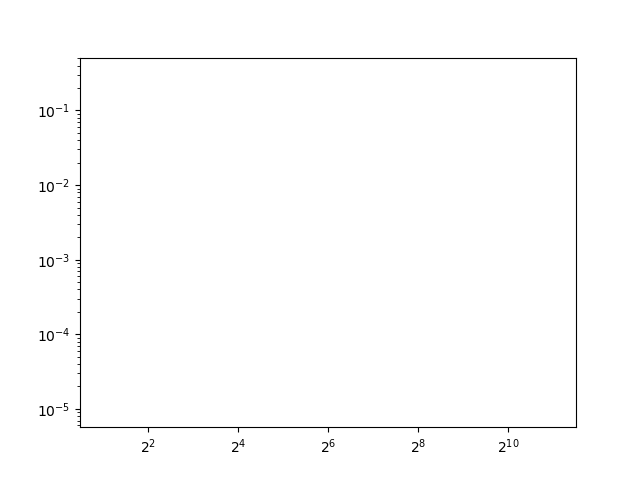

2 | 9.560097401851175e-06
4 | 1.0050079050854232e-05
8 | 1.2961971830011903e-05
16 | 2.5868002915461682e-05
32 | 6.414394057588848e-05
64 | 0.00021884991974127735
128 | 0.0008563126543236526
256 | 0.004192890000001626
512 | 0.018165140000007796
1024 | 0.08131409000000075
2048 | 0.30452311999998755


KeyboardInterrupt: 

In [11]:
testCycle([DFT], end=2**25, verbose=True);